In [8]:
import pandas as pd
from lecilab_behavior_analysis import utils
from pathlib import Path
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# mouse = "mouse2"
# df = utils.load_example_data(mouse)

In [10]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)

['COT_test_data', 'visual_and_COT_data']


In [22]:
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test', 'test2']


In [23]:
# optionally, remove some animals
animals_to_remove = ['test', 'test2']
animals = [animal for animal in animals if animal not in animals_to_remove]
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010']


In [24]:
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_session_data(
        project_name=tv_projects[1],
        animal=mouse,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

receiving incremental file list
ACV001.csv

sent 43 bytes  received 38.853.211 bytes  3.700.309,90 bytes/sec
total size is 221.323.334  speedup is 5,70
receiving incremental file list
ACV002.csv

sent 43 bytes  received 32.102.610 bytes  4.280.353,73 bytes/sec
total size is 188.819.447  speedup is 5,88
receiving incremental file list
ACV003.csv

sent 43 bytes  received 33.601.999 bytes  3.537.057,05 bytes/sec
total size is 191.302.634  speedup is 5,69
receiving incremental file list
ACV004.csv

sent 43 bytes  received 23.998.693 bytes  4.363.406,55 bytes/sec
total size is 135.994.977  speedup is 5,67
receiving incremental file list
ACV005.csv

sent 43 bytes  received 24.444.945 bytes  4.444.543,27 bytes/sec
total size is 138.353.910  speedup is 5,66
receiving incremental file list
ACV006.csv

sent 43 bytes  received 26.315.662 bytes  1.814.876,21 bytes/sec
total size is 149.919.072  speedup is 5,70
receiving incremental file list
ACV007.csv

sent 43 bytes  received 24.469.630 bytes  4.

In [12]:
# download the data for a specific animal

# mouse = "mouse2"
# df = utils.load_example_data(mouse)

mouse = "ACV008"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_session_data(
    project_name=tv_projects[1],
    animal=mouse,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)

receiving incremental file list
ACV008.csv

sent 94.477 bytes  received 161.949 bytes  39.450,15 bytes/sec
total size is 182.863.410  speedup is 713,12


True

In [13]:
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

/tmp/ipykernel_30348/1822815569.py:2: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


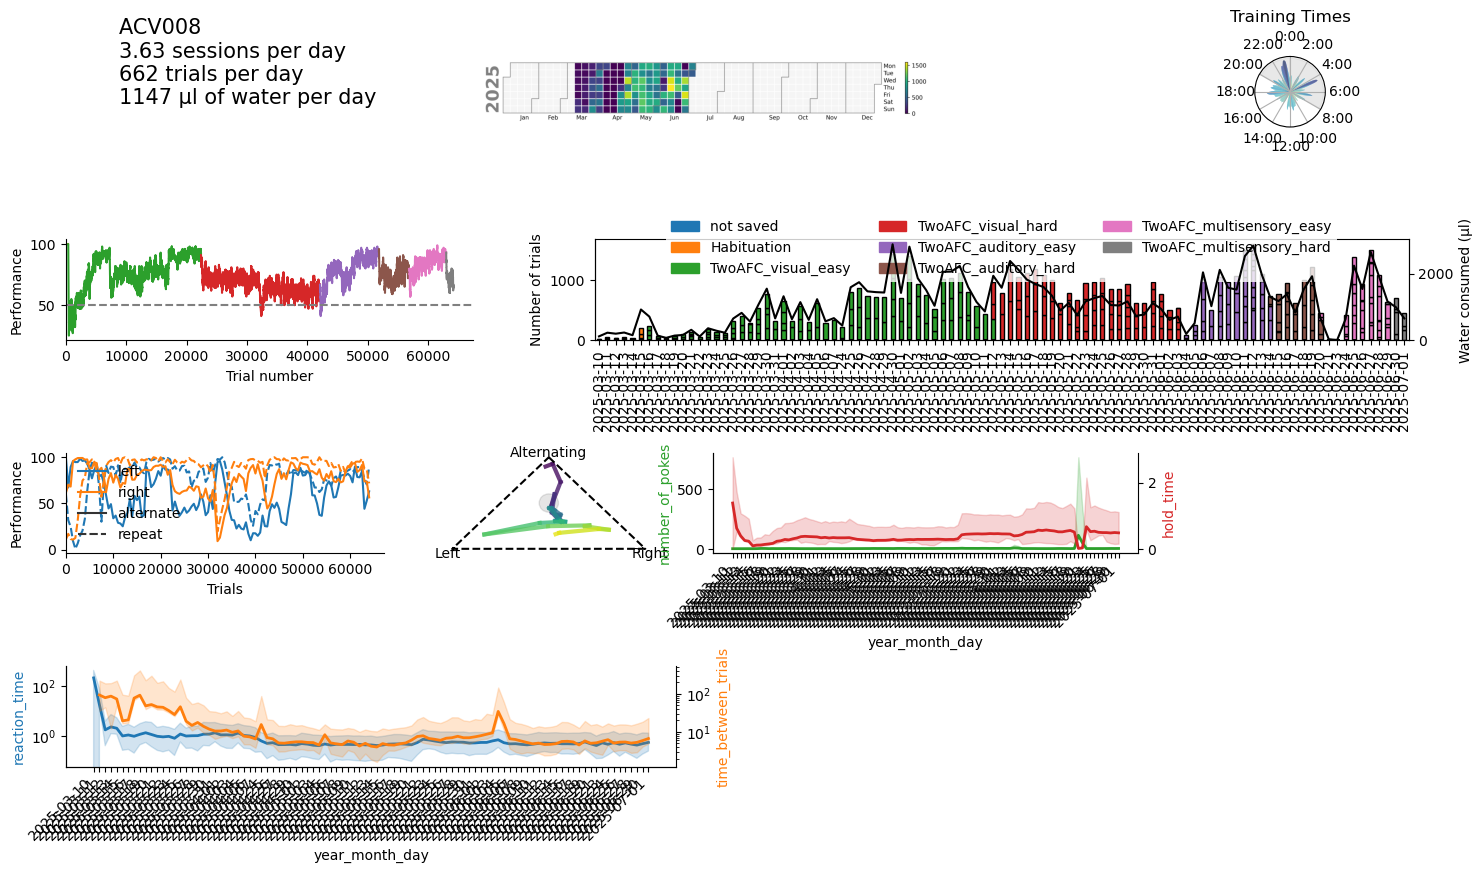

In [14]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, perf_window=100, summary_matrix_plot=False)

<Axes: xlabel='year_month_day', ylabel='number_of_pokes'>

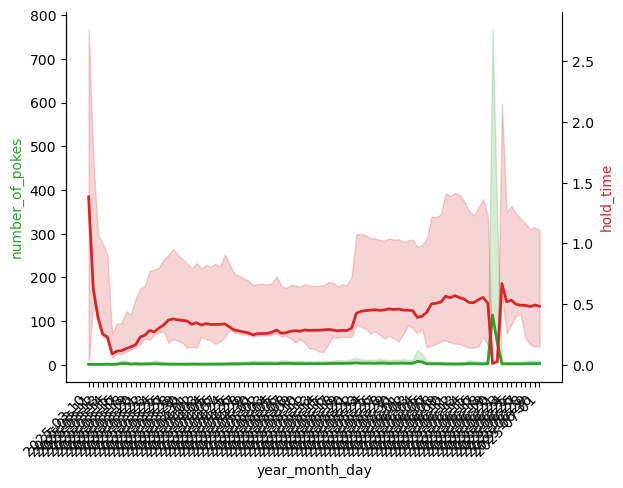

In [15]:
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
df_ch = dft.get_center_hold_df(dft.analyze_df(df))
plots.plot_mean_and_cis_by_date(df_ch, item_to_show="number_of_pokes", group_trials_by="year_month_day", color='tab:green')
plots.plot_mean_and_cis_by_date(df_ch, item_to_show="hold_time", group_trials_by="year_month_day", color='tab:red')

/tmp/ipykernel_30348/4228145416.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf["port2_holds"] = tdf.apply(lambda row: utils.get_trial_port_hold(row, 2), axis=1)


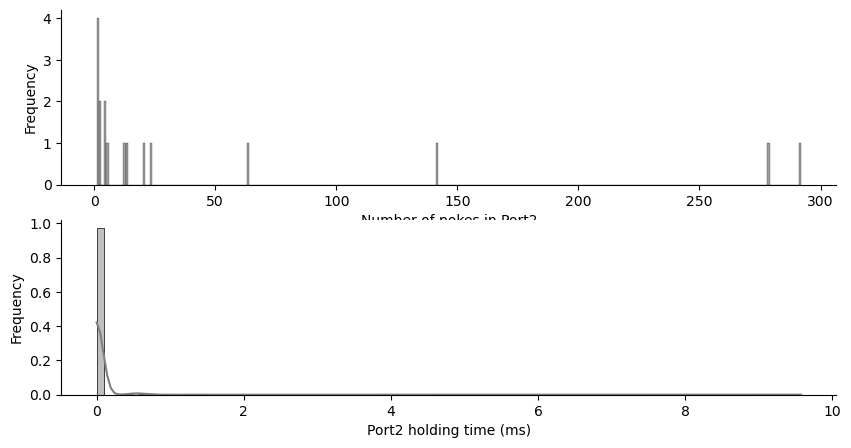

In [16]:
from lecilab_behavior_analysis.df_transforms import add_trial_of_day_column_to_df, add_day_column_to_df
import matplotlib.pyplot as plt

df = add_day_column_to_df(df)
df = add_trial_of_day_column_to_df(df)

tdf = df[df["year_month_day"] == "2025-06-21"]

tdf["port2_holds"] = tdf.apply(lambda row: utils.get_trial_port_hold(row, 2), axis=1)
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
ax1 = plots.plot_number_of_pokes_histogram(tdf, port_number=2, ax=axs[0])
ax2 = plots.plot_port_holding_time_histogram(tdf, port_number=2, ax=axs[1])

plt.show()

In [ ]:
# # load the data if cluster is down
# mouse_path = utils.get_outpath() + "/visual_and_COT_data/sessions/ACV008/ACV008.csv"
# df = pd.read_csv(mouse_path, sep=";")

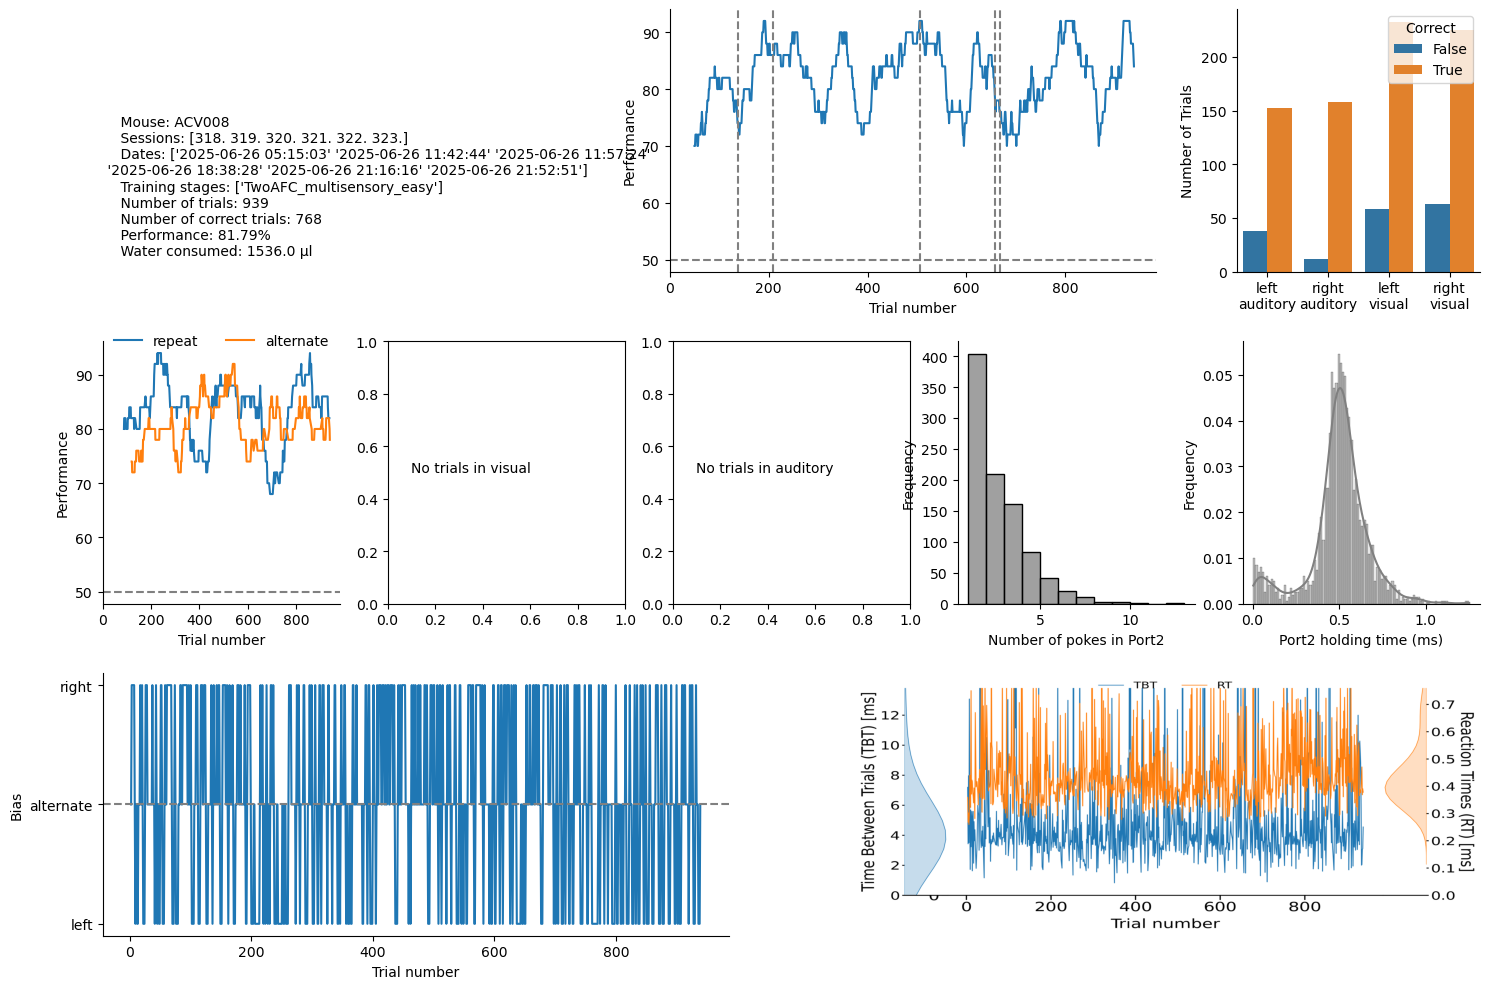

In [17]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
from lecilab_behavior_analysis.df_transforms import add_trial_of_day_column_to_df, add_day_column_to_df
# select the session you want to plot
date = "2025-06-26"
df = add_day_column_to_df(df)
df = add_trial_of_day_column_to_df(df)
sdf = df[df["year_month_day"] == date]
fig = session_summary_figure(sdf, perf_window=50, width=15, height=10)

/tmp/ipykernel_30348/3377504738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf["total_trial"] = np.arange(1, sdf.shape[0] + 1)


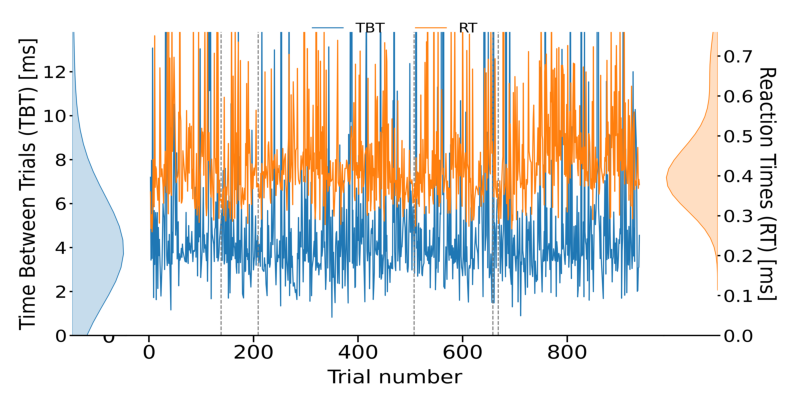

In [18]:
import lecilab_behavior_analysis.plots as plots
import lecilab_behavior_analysis.df_transforms as dft
import matplotlib.pyplot as plt
import numpy as np
sdf["total_trial"] = np.arange(1, sdf.shape[0] + 1)
# find the index of the session changes
session_changes = sdf[sdf.session != sdf.session.shift(1)].index
sdf = dft.calculate_time_between_trials_and_reaction_time(sdf)

# test = plots.plot_time_between_trials_and_reaction_time(sdf, session_changes=session_changes)

reaction_time_image = plots.rasterize_plot(plots.plot_time_between_trials_and_reaction_time(sdf, session_changes=session_changes), dpi=300)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(reaction_time_image, aspect='auto')
plt.axis('off')
plt.show()

In [19]:
from lecilab_behavior_analysis.plots import plot_time_between_trials_and_reaction_time
from lecilab_behavior_analysis.df_transforms import calculate_time_between_trials_and_reaction_time
session = 28
sdf = df[df["session"] == session]
ssdf = calculate_time_between_trials_and_reaction_time(sdf)
ssdf


,session,date,trial,subject,task,system_name,run_mode,Port1In,Port1Out,Port2In,...,holding_time,ordered_list_of_events,stimulus_modality,stimulus_modality_block_number,visual_stimulus,water,year_month_day,trial_of_day,time_between_trials,reaction_time
661,28.0,2025-03-17 13:03:03,1.0,ACV008,TwoAFC,village01,Auto,"[1742213013.105653, 1742213030.493553, 1742213...","[1742213014.441953, 1742213032.810253, 1742213...",[1742213073.817553],...,0.127,"['Tup', 'Port3In', 'Port3Out', 'Port1In', 'Por...",visual,NaN,"(0.6500955958907141, 0.13001911917814282)",2.0,2025-03-17,1.0,NaN,0.8777
662,28.0,2025-03-17 13:03:03,2.0,ACV008,TwoAFC,village01,Auto,[1742213104.010824],"[1742213080.995024, 1742213104.297224]","[1742213083.579824, 1742213102.6317239]",...,0.127,"['Tup', 'Port1Out', 'Port2In', 'Port2Out', 'Po...",visual,NaN,"(0.9134356131920768, 0.18268712263841536)",2.0,2025-03-17,2.0,28.787271,1.2052
663,28.0,2025-03-17 13:03:03,3.0,ACV008,TwoAFC,village01,Auto,NaN,NaN,"[1742213139.1665642, 1742213139.6008642]",...,0.128,"['Tup', 'Port2In', 'Port2Out', 'Port2In', 'Tup...",visual,NaN,"(0.7855743124445738, 0.15711486248891476)",2.0,2025-03-17,3.0,36.958240,1.2725
664,28.0,2025-03-17 13:03:03,4.0,ACV008,TwoAFC,village01,Auto,[1742213158.022661],[1742213158.639961],"[1742213156.627061, 1742213157.0369608]",...,0.129,"['Tup', 'Port3In', 'Port3Out', 'Port2In', 'Por...",visual,NaN,"(0.6432104645232773, 0.12864209290465548)",2.0,2025-03-17,4.0,17.445297,0.8135
665,28.0,2025-03-17 13:03:03,5.0,ACV008,TwoAFC,village01,Auto,[1742213230.45469],[1742213235.44939],"[1742213160.80339, 1742213229.34879]",...,0.130,"['Tup', 'Port2In', 'Port2Out', 'Port3In', 'Por...",visual,NaN,"(0.6052063393197494, 0.12104126786394989)",2.0,2025-03-17,5.0,72.277329,0.9682
666,28.0,2025-03-17 13:03:03,6.0,ACV008,TwoAFC,village01,Auto,"[1742213254.549766, 1742213255.013066]","[1742213254.713866, 1742213255.114866]","[1742213243.362066, 1742213246.133266, 1742213...",...,0.130,"['Tup', 'Port2In', 'Port2Out', 'Port2In', 'Por...",visual,NaN,"(0.07954338079603737, 0.015908676159207474)",2.0,2025-03-17,6.0,17.340976,1.4087
667,28.0,2025-03-17 13:03:03,7.0,ACV008,TwoAFC,village01,Auto,"[1742213266.788923, 1742213267.214323]","[1742213266.963923, 1742213267.404323]","[1742213257.393223, 1742213265.612323]",...,0.130,"['Tup', 'Port2In', 'Port2Out', 'Port2In', 'Tup...",visual,NaN,"(0.6538936017581407, 0.13077872035162813)",2.0,2025-03-17,7.0,19.064257,0.8972
668,28.0,2025-03-17 13:03:03,8.0,ACV008,TwoAFC,village01,Auto,"[1742213322.199105, 1742213322.796405, 1742213...","[1742213322.378705, 1742213322.945005, 1742213...","[1742213273.027005, 1742213279.099805, 1742213...",...,0.130,"['Tup', 'Port2In', 'Port2Out', 'Port2In', 'Por...",visual,NaN,"(0.13989378376946876, 0.027978756753893753)",2.0,2025-03-17,8.0,94.369282,0.8202
669,28.0,2025-03-17 13:03:03,9.0,ACV008,TwoAFC,village01,Auto,"[1742213403.442391, 1742213430.786991, 1742213...","[1742213403.5792909, 1742213431.134291, 174221...","[1742213399.296391, 1742213404.558091, 1742213...",...,0.130,"['Tup', 'Port2In', 'Port2Out', 'Port1In', 'Por...",visual,NaN,"(0.07407768364501364, 0.014815536729002729)",2.0,2025-03-17,9.0,69.750286,0.7757
670,28.0,2025-03-17 13:03:03,10.0,ACV008,TwoAFC,village01,Auto,NaN,NaN,"[1742213432.9522622, 1742213433.405862]",...,0.131,"['Tup', 'Port2In', 'Port2Out', 'Port2In', 'Tup...",visual,NaN,"(0.13774447474822255, 0.027548894949644506)",2.0,2025-03-17,10.0,3.651471,0.8978


In [20]:
ssdf.Reaction_Time.plot(kind="hist", bins=100)

AttributeError: 'DataFrame' object has no attribute 'Reaction_Time'